In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np
import datetime
import glob

Load Data

In [8]:
dummy_date = "2000-01-01" # Dummy date to synchronize time axes (since only H:M:S is needed)

project_path = r"C:\Users\232078\OneDrive - Weir Group PLC\Documents\India_test_data\Cyclone Lab Data 20260206"

LS_data = os.listdir(os.path.join(project_path, "LS"))
HS_data = os.listdir(os.path.join(project_path, "HS"))

LS_data, HS_data

(['AnalogCMv00.SYN0901019FC1_LSDataLogger_20260206T090238+390.csv',
  'AnalogCMv00.SYN0901019FC1_LSDataLogger_20260206T110839+490.csv',
  'AnalogCMv00.SYN0901019FC1_LSDataLogger_20260206T131440+890.csv'],
 ['RawHS.SYN0901019FC1_Fs4000_T300_20260206T104633.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260206T105930.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260206T114341.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260206T120439.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260206T121535.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260206T122815.csv',
  'RawHS.SYN0901019FC1_Fs4000_T300_20260206T124325.csv'])

Concatentate LS_data into one long day

In [3]:
LS_data_continuous = LS_data[:5] # take only the first 5 files, since they are continuous. The rest are separate tests

cols = ["Timestamp", "CL01Flow", "CL01Pressure", "CL01Density"]

dfs = []
for file in LS_data_continuous:
    df = pd.read_csv(Path(project_path) / "LS" / file, usecols=cols)
    dfs.append(df)

LS_whole_day_df = pd.concat(dfs, ignore_index=True)


# Extract hh:mm:ss from "Timestamp"
LS_whole_day_df["Timestamp"] = (
    LS_whole_day_df["Timestamp"]
    .astype(str)
    .str.extract(r"T(\d{6})", expand=False)
)


# convert to datetime.time only if not already in that format
if not isinstance(LS_whole_day_df["Timestamp"].iloc[0], datetime.time):
    LS_whole_day_df["Timestamp"] = pd.to_datetime(LS_whole_day_df["Timestamp"].astype(str).str.zfill(6), format="%H%M%S").dt.time

LS_whole_day_df


,Timestamp,CL01Pressure,CL01Flow,CL01Density
0,09:02:40,5.053865,0.197760,0.0
1,09:02:42,5.127110,0.230720,0.0
2,09:02:44,5.053865,0.153813,0.0
3,09:02:46,5.127110,0.582293,0.0
4,09:02:48,5.127110,0.164800,0.0
...,...,...,...,...
10795,15:20:32,0.585955,0.362560,0.0
10796,15:20:34,0.585955,0.340587,0.0
10797,15:20:36,0.585955,0.307627,0.0
10798,15:20:38,0.585955,0.384533,0.0


# Plotting HS and LS data

C:\Users\232078\AppData\Local\Temp\ipykernel_26424\3624679755.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  LS_whole_day_df['Timestamp'] = pd.to_datetime(LS_whole_day_df['Timestamp'])


FileNotFoundError: [Errno 2] No such file or directory: 'RawHS.SYN0901019FC1_Fs4000_T300_20260206T121535.csv'

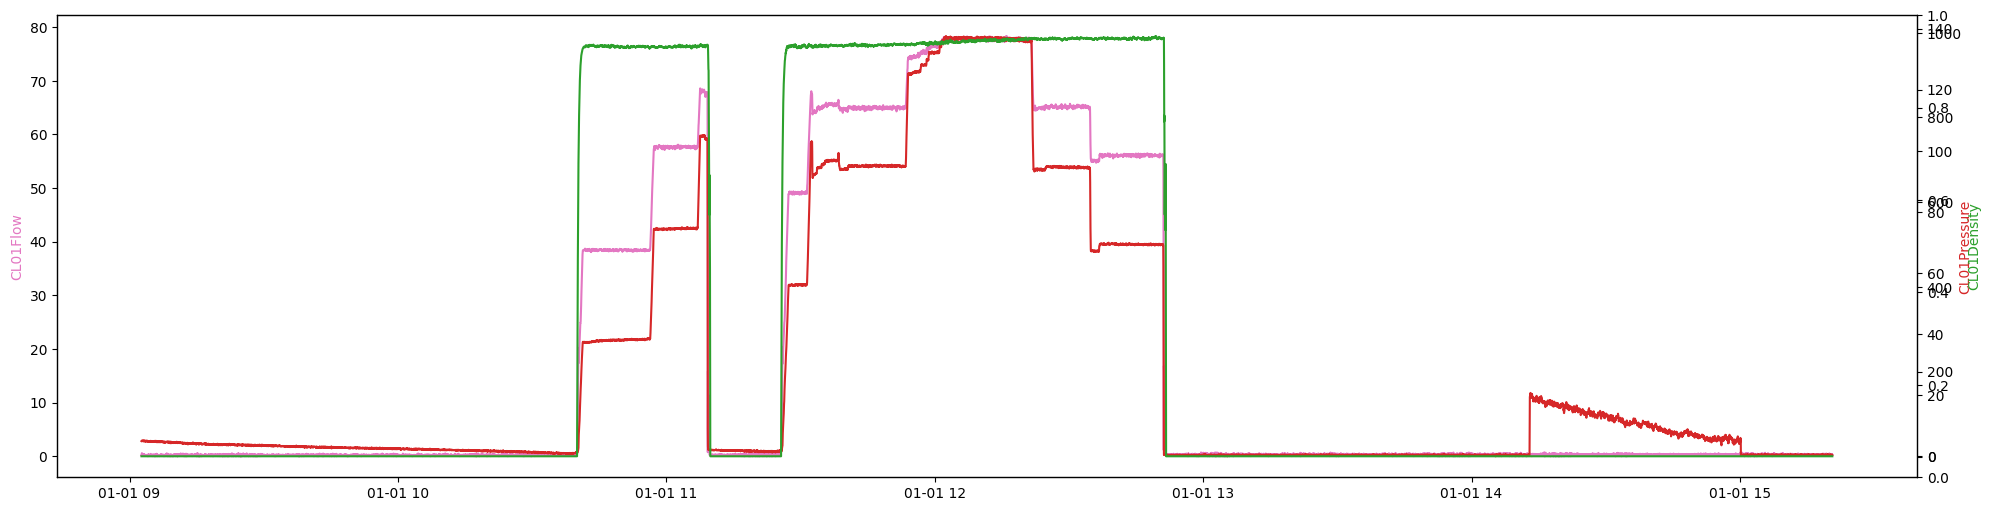

In [6]:
# --- Inputs ---
dummy_date = "2000-01-01"              # already used in your LS code
T_minutes = 5                          # because filename contains _T300 (300 seconds)
# HS_folder = rf"{project_path}\HS"    # folder containing HS csv files


# --- LS timestamp prep (same as you did) ---
LS_whole_day_df['Timestamp'] = LS_whole_day_df['Timestamp'].astype(str)
LS_whole_day_df['Timestamp'] = dummy_date + " " + LS_whole_day_df['Timestamp']
LS_whole_day_df['Timestamp'] = pd.to_datetime(LS_whole_day_df['Timestamp'])

LS_start_time = LS_whole_day_df["Timestamp"].iloc[0]
LS_end_time   = LS_whole_day_df["Timestamp"].iloc[-1]
LS_time_axis  = pd.date_range(start=LS_start_time, end=LS_end_time, periods=LS_whole_day_df.shape[0]).tz_localize(None)  # Remove timezone if present

# --- Collect HS files ---
# hs_files = sorted(glob.glob(os.path.join(HS_data, "RawHS*.csv")))

# --- Plot ---
fig, ax = plt.subplots(figsize=(24, 6))
ax.plot(LS_time_axis, LS_whole_day_df['CL01Flow'], linewidth=1.5, color="tab:pink", label="CL01Flow")
ax.set_ylabel("CL01Flow", color="tab:pink")

ax2 = ax.twinx()
ax2.plot(LS_time_axis, LS_whole_day_df['CL01Pressure'], linewidth=1.5, color="tab:red", label="CL01Pressure")
ax2.set_ylabel("CL01Pressure", color="tab:red")

ax3 = ax.twinx()
ax3.plot(LS_time_axis, LS_whole_day_df['CL01Density'], linewidth=1.5, color="tab:green", label="CL01Density")
ax3.set_ylabel("CL01Density", color="tab:green")


ax4 = ax.twinx()
for hs_file_path in HS_data:
    hs_file = os.path.basename(hs_file_path)

    HS_df = pd.read_csv(hs_file_path)

    cols = [c for c in HS_df.columns if c.startswith("CY_1_T+")]
    if not cols:
        print(f"Skipping {hs_file}: no CY_1_T+ columns found")
        continue

    HS_df_conc = HS_df[cols].stack().reset_index(drop=True).to_frame("CY_1")

    # Parse start time from filename: ..._T300_YYYYMMDDTHHMMSS.csv
    # You used: HS_file.split("_T300")[1].split("T")[1][:6]
    # We'll keep your approach but make it a touch safer:
    try:
        hhmmss = hs_file.split("_T300")[1].split("T")[1][:6]
    except Exception:
        print(f"Skipping {hs_file}: couldn't parse time from filename")
        continue

    hs_start_time = pd.to_datetime(hhmmss, format="%H%M%S").replace(year=2000, month=1, day=1)
    hs_end_time   = hs_start_time + pd.Timedelta(minutes=T_minutes)

    hs_time_axis = pd.date_range(start=hs_start_time, end=hs_end_time, periods=HS_df_conc.shape[0])

    print(f"Plotting {hs_file} with start time {hhmmss} (HS time axis: {hs_time_axis[0]} to {hs_time_axis[-1]})")

    # Plot each file; label with HH:MM:SS so legend is readable
    ax4.plot(hs_time_axis, HS_df_conc["CY_1"], linewidth=0.25, alpha=0.8, label=hhmmss)

# # Make legend manageable (7 files is fine)
# ax4.legend(title="HS start (HHMMSS)", loc="lower left", fontsize=8)

# ---- Combined legend across axes ----
axes = [ax, ax2, ax3]
handles, labels = [], []
for a in axes:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)


fig.legend(handles, labels, loc="lower left", fontsize=8, frameon=True)


ax.set_title("Whole Day Datastream")
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# Cleaner Separation

C:\Users\232078\AppData\Local\Temp\ipykernel_20736\2921569591.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  LS_whole_day_df['Timestamp'] = pd.to_datetime(LS_whole_day_df['Timestamp'])


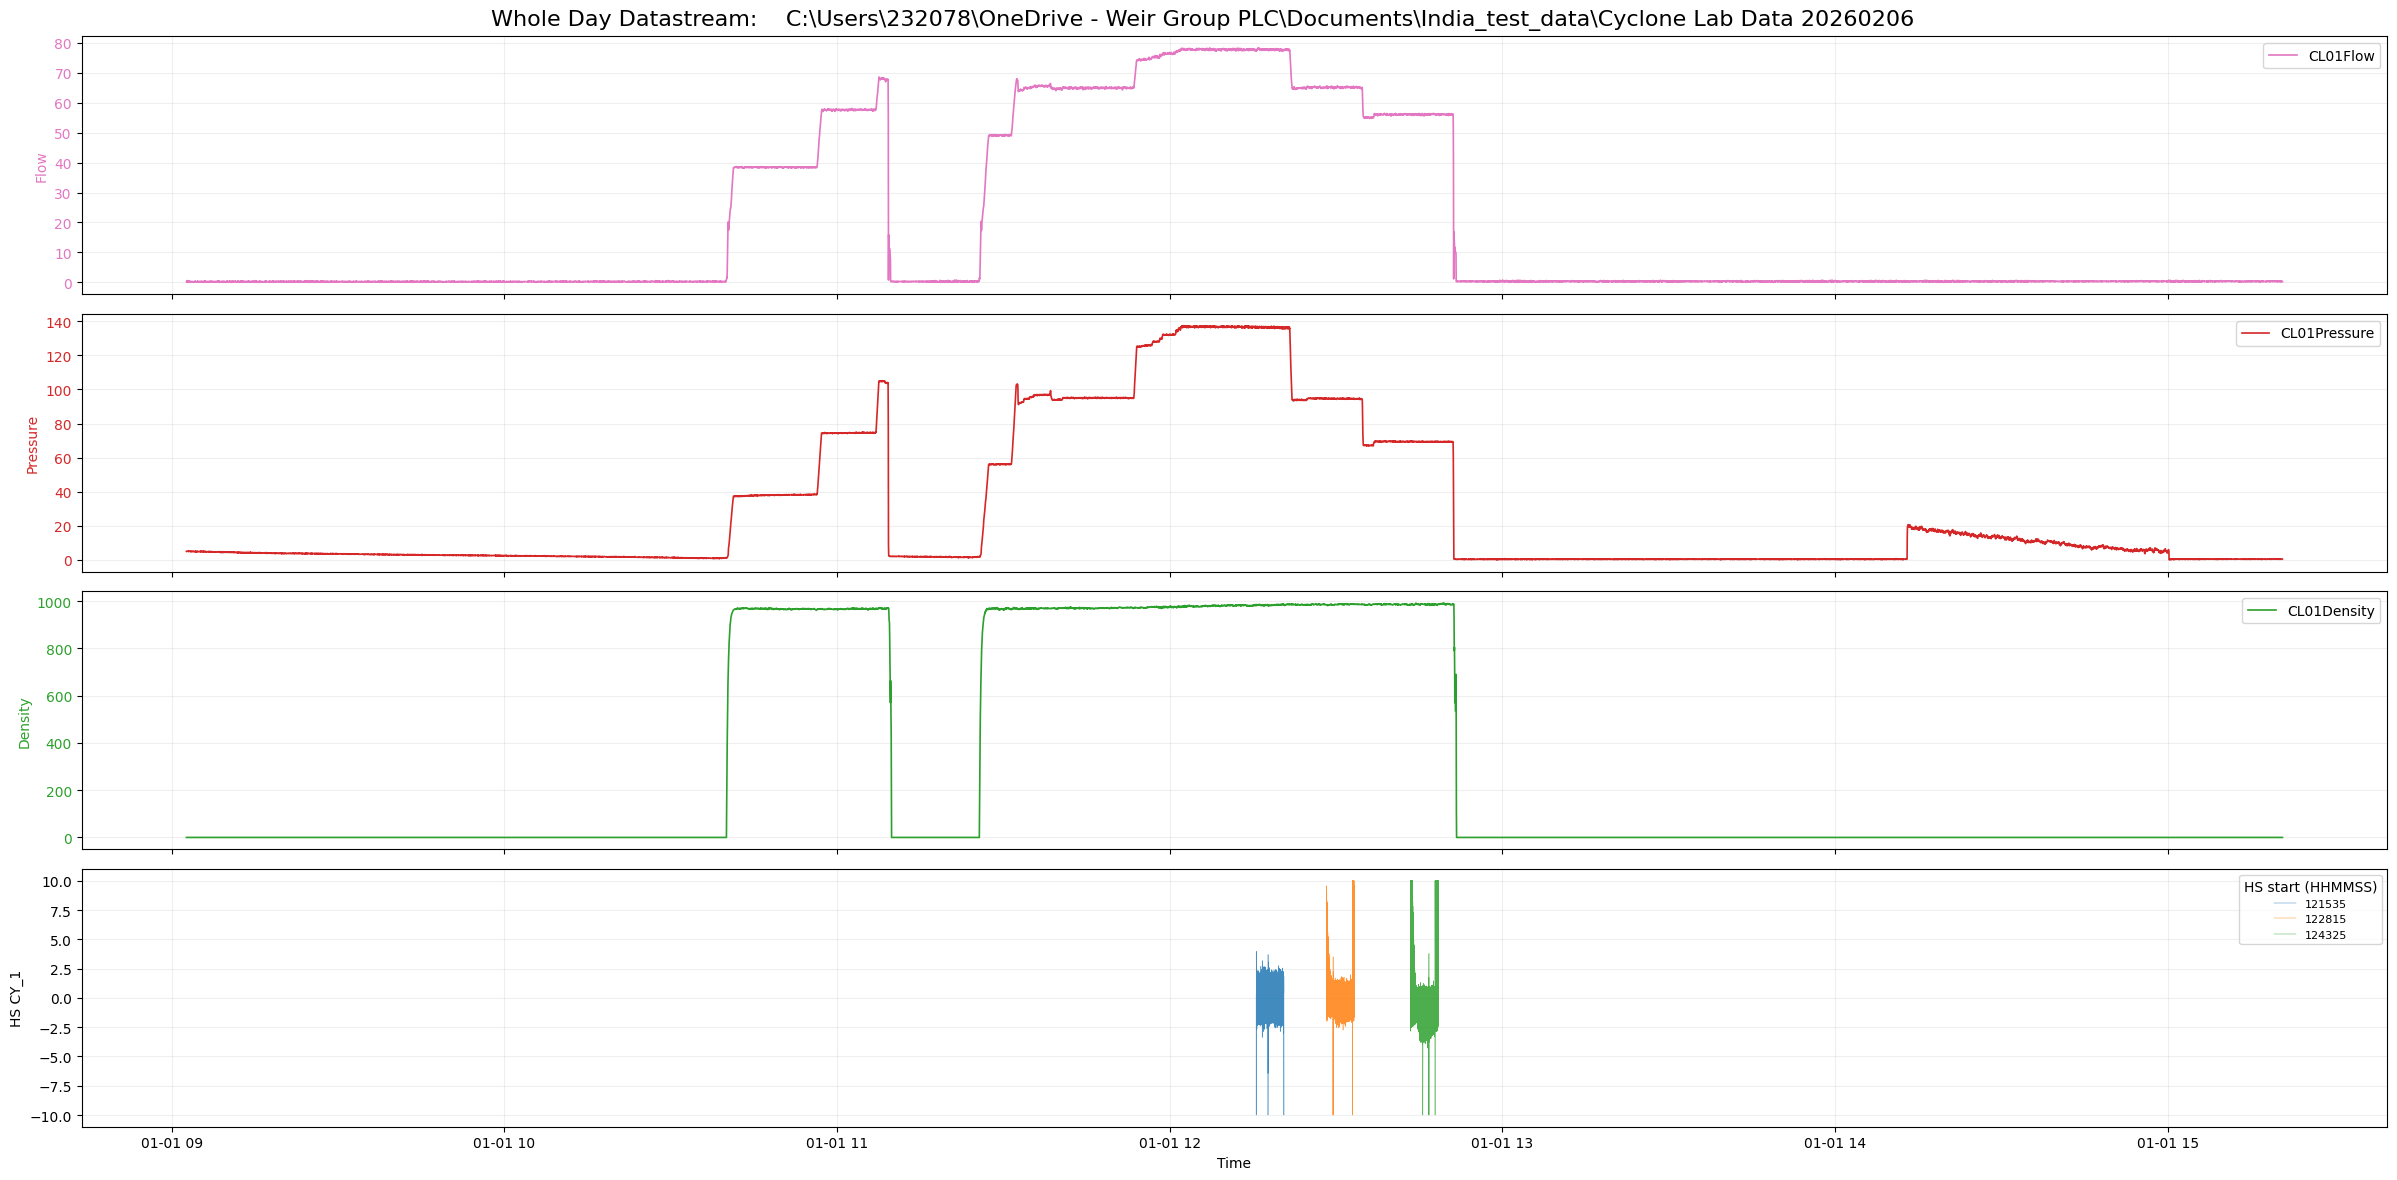

In [ ]:
# --- Inputs ---
hs_folder = rf"{project_path}\HS_vertical"       # folder containing HS csv files
dummy_date = "2000-01-01"
T_minutes = 5                           # filename contains _T300 (300 seconds)

# --- LS timestamp prep ---
LS_whole_day_df['Timestamp'] = LS_whole_day_df['Timestamp'].astype(str)
LS_whole_day_df['Timestamp'] = dummy_date + " " + LS_whole_day_df['Timestamp']
LS_whole_day_df['Timestamp'] = pd.to_datetime(LS_whole_day_df['Timestamp'])

LS_start_time = LS_whole_day_df["Timestamp"].iloc[0]
LS_end_time   = LS_whole_day_df["Timestamp"].iloc[-1]
LS_time_axis  = pd.date_range(
    start=LS_start_time,
    end=LS_end_time,
    periods=LS_whole_day_df.shape[0]
).tz_localize(None)

# --- Collect HS files ---
hs_files = sorted(glob.glob(os.path.join(hs_folder, "RawHS*.csv")))

# --- Plot: 4 panels, shared X ---
fig, axes = plt.subplots(
    nrows=4, ncols=1,
    figsize=(24, 12),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 1, 1, 1]}
)

ax_flow, ax_press, ax_dens, ax_hs = axes

# ---- Panel 1: Flow ----
ax_flow.plot(LS_time_axis, LS_whole_day_df["CL01Flow"],
             linewidth=1.2, color="tab:pink", label="CL01Flow")
ax_flow.set_ylabel("Flow", color="tab:pink")
ax_flow.tick_params(axis="y", labelcolor="tab:pink")
ax_flow.grid(True, alpha=0.2)
ax_flow.legend(loc="upper right")

# ---- Panel 2: Pressure ----
ax_press.plot(LS_time_axis, LS_whole_day_df["CL01Pressure"],
              linewidth=1.2, color="tab:red", label="CL01Pressure")
ax_press.set_ylabel("Pressure", color="tab:red")
ax_press.tick_params(axis="y", labelcolor="tab:red")
ax_press.grid(True, alpha=0.2)
ax_press.legend(loc="upper right")

# ---- Panel 3: Density ----
ax_dens.plot(LS_time_axis, LS_whole_day_df["CL01Density"],
             linewidth=1.2, color="tab:green", label="CL01Density")
ax_dens.set_ylabel("Density", color="tab:green")
ax_dens.tick_params(axis="y", labelcolor="tab:green")
ax_dens.grid(True, alpha=0.2)
ax_dens.legend(loc="upper right")

# ---- Panel 4: HS concentration (each file overlaid) ----
for hs_file_path in hs_files:
    hs_file = os.path.basename(hs_file_path)
    HS_df = pd.read_csv(hs_file_path)

    cols = [c for c in HS_df.columns if c.startswith("CY_1_T+")]
    if not cols:
        print(f"Skipping {hs_file}: no CY_1_T+ columns found")
        continue

    HS_df_conc = HS_df[cols].stack().reset_index(drop=True).to_frame("CY_1")

    # Parse start time from filename: ..._T300_YYYYMMDDTHHMMSS.csv
    try:
        hhmmss = hs_file.split("_T300")[1].split("T")[1][:6]
    except Exception:
        print(f"Skipping {hs_file}: couldn't parse time from filename")
        continue

    hs_start_time = pd.to_datetime(hhmmss, format="%H%M%S").replace(year=2000, month=1, day=1)
    hs_end_time   = hs_start_time + pd.Timedelta(minutes=T_minutes)

    hs_time_axis = pd.date_range(start=hs_start_time, end=hs_end_time,
                                 periods=HS_df_conc.shape[0])

    ax_hs.plot(hs_time_axis, HS_df_conc["CY_1"],
               linewidth=0.35, alpha=0.85, label=hhmmss)

ax_hs.set_ylabel("HS CY_1")
ax_hs.set_xlabel("Time")
ax_hs.grid(True, alpha=0.2)

# Make HS legend manageable
if len(hs_files) <= 12:
    ax_hs.legend(title="HS start (HHMMSS)", loc="upper right", fontsize=8)

fig.suptitle(f"Whole Day Datastream:    {project_path}", fontsize=16)
plt.tight_layout()
plt.show()

# For Debugging Single HS Files (if needed)

In [ ]:
HS_file = "RawHS.SYN0901019FC1_Fs4000_T300_20260204T180402.csv" # example file to test the parsing and plotting of one HS file

HS_df = pd.read_csv(rf"{project_path}\HS\{HS_file}")

cols = [c for c in HS_df.columns if c.startswith("CY_1_T+")]

# Stack into one column (drops the column labels automatically)
HS_df_conc = HS_df[cols].stack().reset_index(drop=True).to_frame("CY_1")




LS_whole_day_df['Timestamp'] = LS_whole_day_df['Timestamp'].astype(str)

LS_whole_day_df['Timestamp'] = dummy_date + " " + LS_whole_day_df['Timestamp']

LS_whole_day_df['Timestamp'] = pd.to_datetime(LS_whole_day_df['Timestamp'])

LS_start_time = LS_whole_day_df["Timestamp"].iloc[0]  # Get the first timestamp as the start time
LS_end_time = LS_whole_day_df["Timestamp"].iloc[-1]  # Get the last timestamp as the end time



hs_start_time = HS_file.split("_T300")[1].split("T")[1][:6]
hs_start_time = pd.to_datetime(hs_start_time, format="%H%M%S")
hs_start_time = hs_start_time.replace(year=2000, month=1, day=1) # dummy date to synchronize with LS data

hs_end_time = hs_start_time + pd.Timedelta(minutes=5)



print(LS_start_time) #2000-01-01 08:54:54
print(LS_end_time) #2000-01-01 18:13:46

print(hs_start_time) #2000-01-01 18:04:02
print(hs_end_time) #2000-01-01 18:09:02


LS_time_axis = LS_whole_day_df["Timestamp"].dt.tz_localize(None)  # Remove timezone if present
hs_time_axis = pd.date_range(start=hs_start_time, end=hs_end_time, periods=HS_df_conc.shape[0])


fig, ax = plt.subplots(figsize=(24, 6))
ax.plot(LS_time_axis, LS_whole_day_df['CL01Flow'], linewidth=0.25)

ax2 = ax.twinx()
ax2.plot(hs_time_axis, HS_df_conc['CY_1'], linewidth=0.25)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\232078\\OneDrive - Weir Group PLC\\Documents\\India_test_data\\Cyclone Lab Data 20260206\\HS\\RawHS.SYN0901019FC1_Fs4000_T300_20260204T180402.csv'